# 164992_Fitting+MCMC

Using HD164992 dataset, we demonstrate how to

- perform a max-likelihood fit (with multiple telescopes)
- do an MCMC exploration of the posterior space (with multiple telescopes)


In [1]:
# Preliminary imports
#%pylab osx
%pylab inline
import radvel
import radvel.likelihood
from radvel.plot import orbit_plots
import copy
import pandas as pd
import os
from scipy import optimize
import corner
from astropy.time import Time
import numpy as np
from numpy import *
import copy

rcParams['font.size'] = 18

Populating the interactive namespace from numpy and matplotlib


In [2]:
def bin_same_night(rv):
    rv['jd_date'] = rv['time'].apply(lambda x: np.int(np.floor(x)))
    rv_mean = rv.groupby('jd_date',as_index=False).mean()
    rv_n = rv.groupby('jd_date',as_index=False).size()
    print(rv['tel'].iloc[0])
    print(len(rv_n))
    rv_mean['errvel'] = rv_mean['errvel'] / np.array(np.sqrt(rv_n))
    return rv_mean

path = os.path.join(radvel.DATADIR,'164922_fixed.txt')
data = pd.read_csv(path, usecols=(0,1,2,3), delim_whitespace=True)

rv_hires_rk = data.query("tel == 'k'")
rv_hires_rj = data.query("tel == 'j'")
rv_apf = data.query("tel == 'a'")

rv_hires_rj = bin_same_night(rv_hires_rj)
rv_hires_rk = bin_same_night(rv_hires_rk)
rv_apf = bin_same_night(rv_apf)

t_start = min(data['time'].values)
t_stop = max(data['time'].values)
ti = linspace(t_start,t_stop,10000)

j
122
k
49
a
69


/Users/lee/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [3]:
#Some conveinence functions
def initialize_model():
    time_base = 2456778
    params = radvel.Parameters(1,basis='per tc secosw sesinw logk')
    params['per1'] = radvel.Parameter(value=1201.1 + 0.4)
    params['tc1'] = radvel.Parameter(value=2456778 + 1)
    params['secosw1'] = radvel.Parameter(value=0.01)
    params['sesinw1'] = radvel.Parameter(value=0.01)
    params['logk1'] = radvel.Parameter(value=1)    
    '''
    params['per1'] = radvel.Parameter(value=1201.1 + 0.4)
    params['tc1'] = radvel.Parameter(value=2456778 + 1)
    params['secosw1'] = radvel.Parameter(value=0.01)
    params['sesinw1'] = radvel.Parameter(value=0.01)
    params['logk1'] = radvel.Parameter(value=1)
    params['per2'] = radvel.Parameter(value=75.765 + 0.1)
    params['tc2'] = radvel.Parameter(value=2456277.6)
    params['secosw2'] = radvel.Parameter(value=0.01)
    params['sesinw2'] = radvel.Parameter(value=0.01)
    params['logk2'] = radvel.Parameter(value=1)
    '''
    params['dvdt'] = radvel.Parameter(value=0)
    params['curv'] = radvel.Parameter(value=0)
    mod = radvel.RVModel(params, time_base=time_base)
    return mod


# Max-likelihood fitting

1. Initialize model
2. Build up likelihoods
3. Instantiate posterior
4. Perform fit

In [4]:
def initialize_likelihood(rv,suffix):
    like = radvel.likelihood.RVLikelihood( 
        mod, rv.time, rv.mnvel, rv.errvel,suffix=suffix)
    return like
mod = initialize_model()

# Build up HIRES >2004 likelihood
like_hires_rj = initialize_likelihood(rv_hires_rj,'_hires_rj')
like_hires_rj.params['gamma_hires_rj'] = radvel.Parameter(value=1.0)
like_hires_rj.params['jit_hires_rj'] = radvel.Parameter(value=np.log(1))

# Build up HIRES <2004 likelihood
like_hires_rk = initialize_likelihood(rv_hires_rk,'_hires_rk')
like_hires_rk.params['gamma_hires_rk'] = radvel.Parameter(value=1.0)
like_hires_rk.params['jit_hires_rk'] = radvel.Parameter(value=np.log(1))

# Build up APF
like_apf = initialize_likelihood(rv_apf,'_apf')
like_apf.params['gamma_apf'] = radvel.Parameter(value=1.0)
like_apf.params['jit_apf'] = radvel.Parameter(value=np.log(1))

# Build composite likelihood
like = radvel.likelihood.CompositeLikelihood(
    [like_hires_rj,like_hires_rk,like_apf])

# Set initial values for jitter
like.params['jit_hires_rk'] = radvel.Parameter(value=log(2.6))
like.params['jit_hires_rj'] = radvel.Parameter(value=log(2.6))
like.params['jit_apf'] = radvel.Parameter(value=log(2.6))

# Do not vary dvdt or jitter (Fulton 2015)
like.params['dvdt'].vary = False
like.params['curv'].vary = False
like.params['jit_hires_rk'].vary = False
like.params['jit_hires_rj'].vary = False
like.params['jit_apf'].vary = False

In [5]:
# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
post.priors += [radvel.prior.EccentricityPrior( 1 )] # Keeps eccentricity < 1, assigns #planets

# Perform Max-likelihood fitting
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(), 
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )

print("Initial loglikelihood = %f" % post0.logprob())
print("Final loglikelihood = %f" % post.logprob())
print(post)

Initial loglikelihood = -1599.407181
Final loglikelihood = -897.611511
parameter                     value      vary
per1                         1199.4       True
tc1                         6778.51       True
secosw1                   -0.312595       True
sesinw1                   0.0920866       True
logk1                         1.973       True
dvdt                              0      False
curv                              0      False
gamma_hires_rj              0.09463       True
jit_hires_rj               0.955511      False
gamma_hires_rk             -0.14431       True
jit_hires_rk               0.955511      False
gamma_apf                  0.595543       True
jit_apf                    0.955511      False

Priors
------
e1 constrained to be < 0.99



# Perform MCMC posterior exploration

In [6]:
df = radvel.mcmc(post, nrun=200)

20000/80000 (25.0%) steps complete; Running 7682.75 steps/s; Mean acceptance rate = 50.2%; Min Tz = 7084.0; Max G-R = 1.004      
Discarding burn-in now that the chains are marginally well-mixed

80000/80000 (100.0%) steps complete; Running 7428.91 steps/s; Mean acceptance rate = 45.7%; Min Tz = 4609.2; Max G-R = 1.006      

MCMC: WARNING: chains did not pass 5 consecutive convergence tests. They may be marginally well=mixed.


In [7]:
df_synth = post.params.basis.to_synth(df)
labels = 'per1 tc1 e1 k1 gamma_hires_rj gamma_hires_rk gamma_apf '.split()
#labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 gamma_hires_rj gamma_hires_rk gamma_apf '.split()
df_synth[labels].quantile([0.14,0.5,0.84]).T

,0.14,0.5,0.84
per1,1.197671e+03,1.199388e+03,1.200945e+03
tc1,2.456773e+06,2.456778e+06,2.456782e+06
e1,9.131315e-02,1.067297e-01,1.208208e-01
k1,7.025045e+00,7.195364e+00,7.355658e+00
gamma_hires_rj,-3.227119e-02,9.007137e-02,2.049793e-01
gamma_hires_rk,-3.932256e-01,-1.463891e-01,6.985143e-02
gamma_apf,2.482160e-01,6.191022e-01,9.540446e-01


Compare with parameters from fulton et al. (2016)
---------

# 1 Planet Histograms

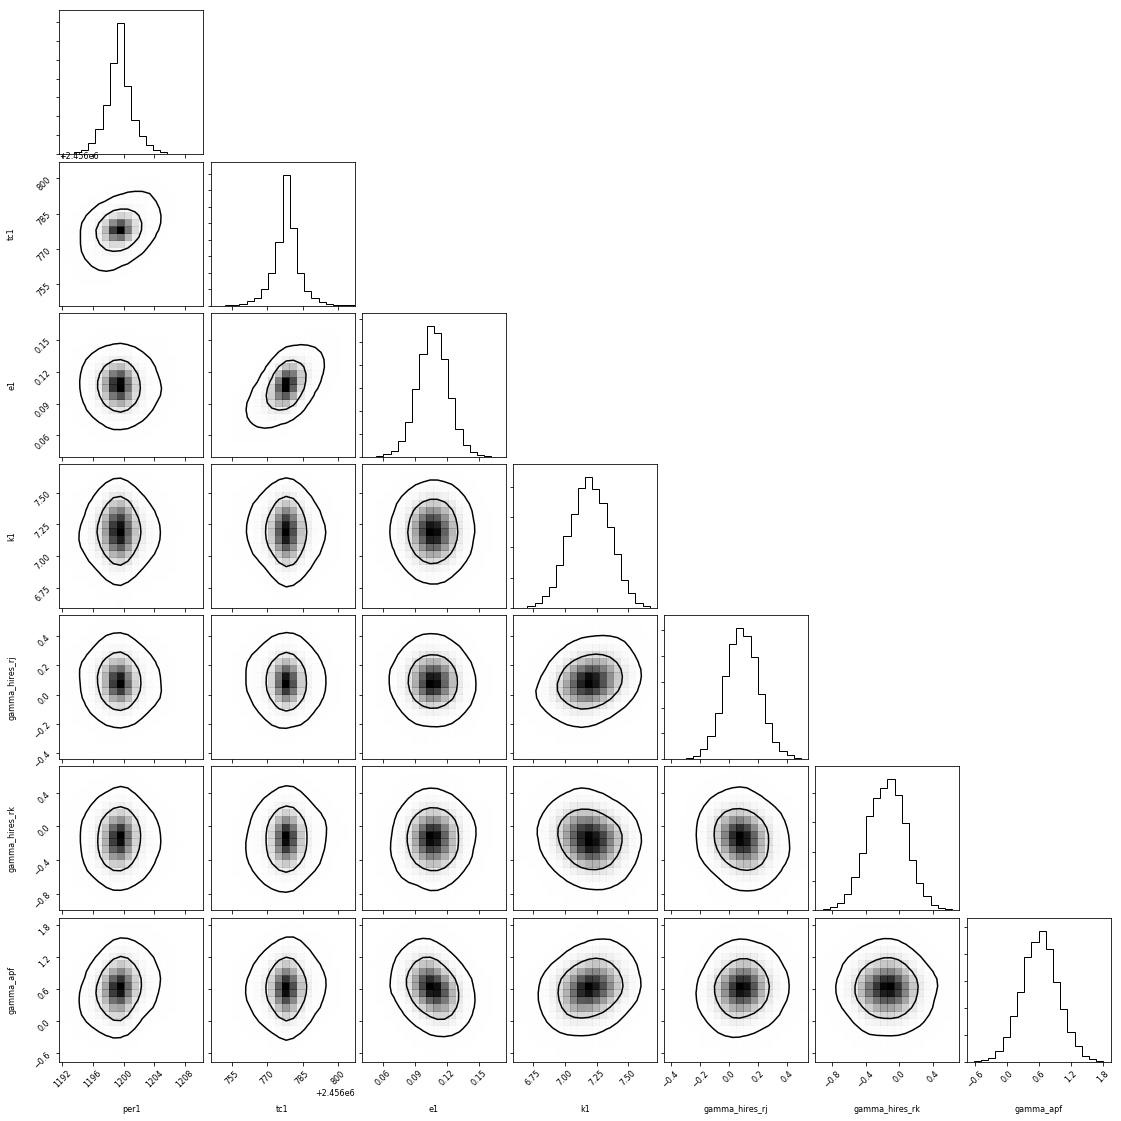

In [8]:
labels = 'per1 tc1 e1 k1 gamma_hires_rj gamma_hires_rk gamma_apf '.split()
#labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 gamma_hires_rj gamma_hires_rk gamma_apf '.split()
rc('font',size=8)

fig = corner.corner(
    df_synth[labels],labels=labels,
    levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

# 1 Planet RV Curves

(<matplotlib.figure.Figure at 0x11cb99c50>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11df50cc0>])

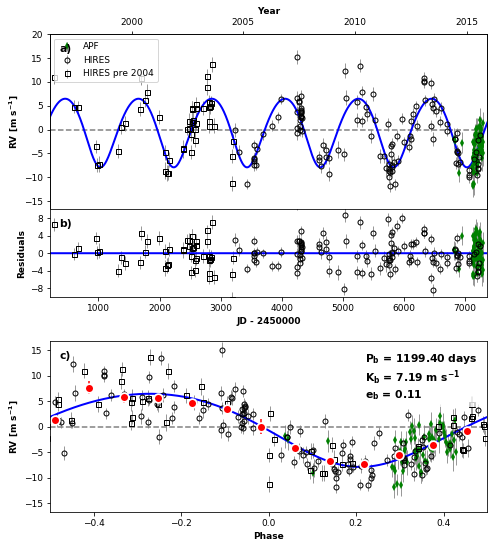

In [9]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()

# 1 Planet BIC.

In [10]:
bic1 = post.bic()
print(bic1)

1839.06813372


# Same stuff, for 3-planet model.

In [11]:
def initialize_model_3():
    time_base = 2456778
    params3 = radvel.Parameters(1,basis='per tc secosw sesinw logk')   
    
    params3['per1'] = radvel.Parameter(value=1201.1 + 0.4)
    params3['tc1'] = radvel.Parameter(value=2456778 + 1)
    params3['secosw1'] = radvel.Parameter(value=0.01)
    params3['sesinw1'] = radvel.Parameter(value=0.01)
    params3['logk1'] = radvel.Parameter(value=1)
    params3['per2'] = radvel.Parameter(value=75.765 + 0.1)
    params3['tc2'] = radvel.Parameter(value=2456277.6)
    params3['secosw2'] = radvel.Parameter(value=0.01)
    params3['sesinw2'] = radvel.Parameter(value=0.01)
    params3['logk2'] = radvel.Parameter(value=1)
    params3['per3'] = radvel.Parameter(value=95.765 + 0.1)
    params3['tc3'] = radvel.Parameter(value=2456477.6)
    params3['secosw3'] = radvel.Parameter(value=0.01)
    params3['sesinw3'] = radvel.Parameter(value=0.01)
    params3['logk3'] = radvel.Parameter(value=1)
    
    params3['dvdt'] = radvel.Parameter(value=0)
    params3['curv'] = radvel.Parameter(value=0)
    mod3 = radvel.RVModel(params3, time_base=time_base)
    return mod3


In [12]:
def initialize_likelihood_3(rv,suffix):
    like3 = radvel.likelihood.RVLikelihood( 
        mod3, rv.time, rv.mnvel, rv.errvel,suffix=suffix)
    return like3
mod3 = initialize_model_3()

# Build up HIRES >2004 likelihood
like_hires_rj3 = initialize_likelihood_3(rv_hires_rj,'_hires_rj')
like_hires_rj3.params['gamma_hires_rj'] = radvel.Parameter(value=1.0)
like_hires_rj3.params['jit_hires_rj'] = radvel.Parameter(value=np.log(1))

# Build up HIRES <2004 likelihood
like_hires_rk3 = initialize_likelihood_3(rv_hires_rk,'_hires_rk')
like_hires_rk3.params['gamma_hires_rk'] = radvel.Parameter(value=1.0)
like_hires_rk3.params['jit_hires_rk'] = radvel.Parameter(value=np.log(1))

# Build up APF
like_apf3 = initialize_likelihood_3(rv_apf,'_apf')
like_apf3.params['gamma_apf'] = radvel.Parameter(value=1.0)
like_apf3.params['jit_apf'] = radvel.Parameter(value=np.log(1))

# Build composite likelihood
like3 = radvel.likelihood.CompositeLikelihood(
    [like_hires_rj3,like_hires_rk3,like_apf3])

# Set initial values for jitter
like3.params['jit_hires_rk'] = radvel.Parameter(value=log(2.6))
like3.params['jit_hires_rj'] = radvel.Parameter(value=log(2.6))
like3.params['jit_apf'] = radvel.Parameter(value=log(2.6))

# Do not vary dvdt or jitter (Fulton 2015)
like3.params['dvdt'].vary = False
like3.params['curv'].vary = False
like3.params['jit_hires_rk'].vary = False
like3.params['jit_hires_rj'].vary = False
like3.params['jit_apf'].vary = False

In [14]:
# Instantiate posterior
post3 = radvel.posterior.Posterior(like3)
post30 = copy.deepcopy(post3)

# Add in priors
post3.priors += [radvel.prior.EccentricityPrior( 3 )] # Keeps eccentricity < 1, assigns #planets

# Perform Max-likelihood fitting
res3  = optimize.minimize(
    post3.neglogprob_array,
    post3.get_vary_params(), 
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )

print("Initial loglikelihood = %f" % post30.logprob())
print("Final loglikelihood = %f" % post3.logprob())
print(post3)

Initial loglikelihood = -897.621562
Final loglikelihood = -897.591100
parameter                     value      vary
per1                         1199.4       True
tc1                         6778.57       True
secosw1                   -0.312576       True
sesinw1                   0.0914535       True
logk1                       1.97288       True
per2                        107.074       True
tc2                         6308.81       True
secosw2                   -0.608035       True
sesinw2                        0.01       True
logk2                        32.209       True
per3                        127.074       True
tc3                         6508.81       True
secosw3                   -0.608035       True
sesinw3                        0.01       True
logk3                        32.209       True
dvdt                              0      False
curv                              0      False
gamma_hires_rj             0.094439       True
jit_hires_rj               0.955511   

/Users/lee/anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [15]:
df3 = radvel.mcmc(post3, nrun=200)

20000/80000 (25.0%) steps complete; Running 6895.64 steps/s; Mean acceptance rate = 39.5%; Min Tz = 5570.6; Max G-R = 1.005      
Discarding burn-in now that the chains are marginally well-mixed

80000/80000 (100.0%) steps complete; Running 7645.45 steps/s; Mean acceptance rate = 26.5%; Min Tz = 2481.1; Max G-R = 1.011      

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


In [16]:
df_synth3 = post3.params.basis.to_synth(df3)
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 per3 tc3 e3 k3 gamma_hires_rj gamma_hires_rk gamma_apf '.split()
df_synth3[labels].quantile([0.14,0.5,0.84]).T

KeyError: "['e2' 'k2' 'e3' 'k3'] not in index"

In [17]:
rc('font',size=8)

fig2 = corner.corner(
    df_synth3[labels],labels=labels,
    levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

KeyError: "['e2' 'k2' 'e3' 'k3'] not in index"

In [18]:
bic3 = post3.bic()
print(bic3)

1893.83370007


In [19]:
bic3-bic1

54.765566348602306

(<matplotlib.figure.Figure at 0x1165ce198>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11415f0b8>])

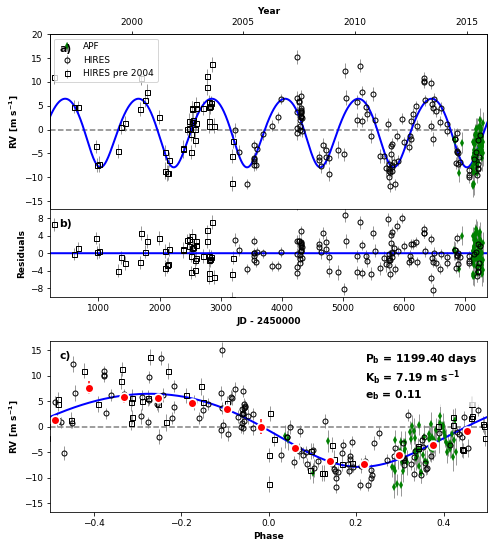

In [20]:
RVPlot3 = orbit_plots.MultipanelPlot(post3)
RVPlot3.plot_multipanel()